# Chapter 16: The Sugarscape

<img src="SU_fig_01.jpg" alt="title" width="600px" />

## Motivation

**The Sugarscape**: Agent-based model with simple rules.
Can account for the transformation of a population through:
- natural selection 
- spatial segregation 
- migration
- emergence of wealth inequalities. 

The model is easily extended by introducing additional rules to add, e.g., trade, reproductive pressure, exchange of information, and environment pollution..


## Applications

- social science
- political science
- cooperation
- economics


## Schelling's model of segregation

Inspiration for the Sugarscape.

**Description of the model:**

- Town with $N^2$ houses (square lattice with $N \times N$ cells)

- $f$ : fraction of empty, available houses

- the rest of the houses is occupied by families of two *kinds* ($A$ and $B$) differing on some characteristics (e.g., language, nutrition habits, religion)

- families *positively* discriminate: each family is happy if they are not in the minority within their neighborhood (Moore's neighborhood)

- each turn a random family is chosen: if unhappy, it randomly relocates in one of the available empty houses.

Schelling showed that **segregation spontaneously emerges**.


### Implementation

Arena with $N \times N$ houses. $N = 10$.

$f$ : fraction of available houses. $f = 0.1$. 
10 houses are available to relocation if needed.

**Happiness:** defined as *not being in the minority* within the Moore's neighborhood.

In this implementation, a cell of the lattice with value:

- $0$ represents a empty house
- $1$ represents a family of type $A$
- $-1$ represents a family of type $B$

We start by randomly populating the lattice with roughly 50% - 50% proportion of $A$ and $B$ families.

## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

For more details: see the book, page 16-5 and on.

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.


In [1]:
# Import dependencies
import pandas as pd
import numpy as np

In [ ]:
def move_agents(SuSca, Agents):
    """
    Function to move the agents on the sugarscape.
    Implements one round where all the agents move once.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the Sugarscape. 
    Agents : Pandas DataFrame containing agent attributes.
    """
    Nx, Ny = SuSca.shape
    
    # Copy Sugarscape and dataframe
    nSuSca = SuSca.copy()
    New_Agents = Agents.copy()

    # Shuffle alive agents for fair movement
    alive_agents = New_Agents[New_Agents["Alive?"]]
    order = np.random.permutation(alive_agents.index)

    for idx in order:
        # Agent attributes
        xa, ya = New_Agents.loc[idx, "X position"], New_Agents.loc[idx, "Y position"]
        ma = New_Agents.loc[idx, "Metabolic Rate"]
        va = New_Agents.loc[idx, "Vision"]
        sa = New_Agents.loc[idx, "Sugar Level"]

        # Search cells within vision range
        rx = np.zeros(va * 4 + 1) + xa
        ry = np.zeros(va * 4 + 1) + ya
        rx[0] = xa
        ry[0] = ya
        rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
        rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
        ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
        ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1
        rx = rx.astype(int) % Nx
        ry = ry.astype(int) % Ny

        # Find the best cell with the most sugar
        sugar = nSuSca[rx, ry]
        max_sugar = np.amax(sugar)
        sugar_level = max_sugar
        place_found = False

        while not place_found and sugar_level >= 0:
            options = np.where(sugar == sugar_level)[0]
            for i in options:
                x_ref, y_ref = int(rx[i]), int(ry[i])
                is_occupied = (
                    (New_Agents["X position"] == x_ref) & 
                    (New_Agents["Y position"] == y_ref) & 
                    (New_Agents["Alive?"])
                ).any()
                if not is_occupied:
                    # Move agent to new position
                    New_Agents.loc[idx, "X position"] = x_ref
                    New_Agents.loc[idx, "Y position"] = y_ref
                    New_Agents.loc[idx, "Sugar Level"] += nSuSca[x_ref, y_ref]
                    nSuSca[x_ref, y_ref] = 0
                    place_found = True
                    break
            sugar_level -= 1

        if not place_found:
            # Stay in current position
            New_Agents.loc[idx, "Sugar Level"] += nSuSca[xa, ya]
            nSuSca[xa, ya] = 0

    # Apply metabolic cost and update alive status
    New_Agents["Sugar Level"] -= New_Agents["Metabolic Rate"]
    New_Agents["Alive?"] = New_Agents["Sugar Level"] > 0

    return nSuSca, New_Agents


Initialize the sugarscape in the "classical" way.

In [3]:
def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    SuSca = np.zeros([N, N])
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    for k in range(np.size(x_centers)):
        d = np.sqrt((X - x_centers[k]) ** 2 +
                    (Y - y_centers[k]) ** 2)
        for i in range(np.size(s_levels)):
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca


Function to convert a 2 dimensional numpy array into a RGB image.

In [4]:
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Check whether the initialization works.

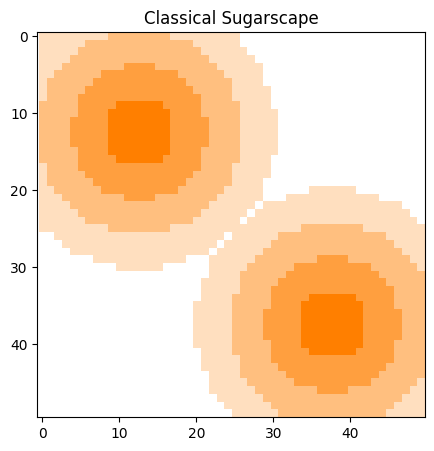

In [5]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.

SuSca = initialize_sugarscape(N)

# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [6]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
M = np.random.randint(np.size(possible_m), size=A) + 1
V = np.random.randint(np.size(possible_v), size=A) + 1
S = np.random.randint(np.size(possible_s), size=A) + 5


# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 

# New Initialize agents
data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolic Rate": np.random.randint(np.size(possible_m), size=A)+1,
    "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
    "Sugar Level": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}

Agents = pd.DataFrame(data)

# This way each agent occupy a different cell.

SuSca = initialize_sugarscape(N)

# nSuSca = move_agents(SuSca, N, Agents_df)

In [7]:
Agents.iloc[np.where(M <= 2)[0],5] = False

In [8]:
np.where(M <= 2)[0], 5

(array([  0,   1,   4,   5,   6,   8,  13,  14,  15,  17,  22,  26,  27,
         29,  30,  33,  35,  37,  38,  39,  40,  42,  44,  45,  46,  47,
         50,  51,  55,  56,  58,  61,  65,  66,  68,  69,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  82,  85,  86,  87,  89,  93,
         95,  97,  98,  99, 102, 103, 111, 113, 114, 115, 116, 117, 118,
        119, 125, 127, 129, 133, 134, 135, 138, 141, 142, 146, 147, 148,
        149, 150, 152, 156, 158, 163, 166, 167, 168, 169, 170, 174, 175,
        177, 178, 181, 182, 183, 185, 194, 195, 196, 199, 202, 213, 214,
        215, 217, 218, 223, 226, 228, 230, 232, 234, 235, 236, 238, 239,
        240, 243, 244, 247, 248, 252, 253, 254, 256, 257, 258, 260, 262,
        264, 265, 266, 267, 271, 273, 274, 275, 278, 279, 280, 281, 283,
        284, 287, 289, 290, 293, 300, 303, 304, 305, 307, 310, 312, 315,
        316, 317, 318, 319, 320, 321, 322, 325, 326, 328, 329, 332, 336,
        338, 339, 341, 342, 343, 347, 350, 351, 359

In [9]:
still_alive = np.where(Agents["Alive?"] == True)[0]

In [10]:
still_alive

array([  2,   3,   7,   9,  10,  11,  12,  16,  18,  19,  20,  21,  23,
        24,  25,  28,  31,  32,  34,  36,  41,  43,  48,  49,  52,  53,
        54,  57,  59,  60,  62,  63,  64,  67,  70,  81,  83,  84,  88,
        90,  91,  92,  94,  96, 100, 101, 104, 105, 106, 107, 108, 109,
       110, 112, 120, 121, 122, 123, 124, 126, 128, 130, 131, 132, 136,
       137, 139, 140, 143, 144, 145, 151, 153, 154, 155, 157, 159, 160,
       161, 162, 164, 165, 171, 172, 173, 176, 179, 180, 184, 186, 187,
       188, 189, 190, 191, 192, 193, 197, 198, 200, 201, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 216, 219, 220, 221, 222, 224,
       225, 227, 229, 231, 233, 237, 241, 242, 245, 246, 249, 250, 251,
       255, 259, 261, 263, 268, 269, 270, 272, 276, 277, 282, 285, 286,
       288, 291, 292, 294, 295, 296, 297, 298, 299, 301, 302, 306, 308,
       309, 311, 313, 314, 323, 324, 327, 330, 331, 333, 334, 335, 337,
       340, 344, 345, 346, 348, 349, 352, 353, 354, 355, 356, 35

In [11]:
import time
from tkinter import Tk, Canvas

r0 = 0.25  # Radius of agents in the visualization
N_skip = 1  # Visualize every N_skip steps
MAX_STEP = 1001  # Maximum simulation steps
N_alive_agents = np.zeros(MAX_STEP)  # Tracks alive agents over time

# Visualization settings
window_size = 600
cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']  # Sugar levels

# Initialize Tkinter window
tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')
canvas = Canvas(tk, background='#ECECEC')  # Create animation window
tk.attributes('-topmost', 0)
canvas.place(x=10, y=10, height=window_size, width=window_size)

step = 0
running = True  # Flag to control the loop

# Function to stop the simulation with the Escape key
def stop_loop(event):
    global running
    running = False

tk.bind("<Escape>", stop_loop)  # Bind the Escape key

while running:
    # Perform one step of the simulation
    nSuSca, Agents = move_agents(SuSca, Agents)
    
    # Identify alive agents
    still_alive = Agents[Agents["Alive?"]].index
    N_alive_agents[step] = len(still_alive)
    
    # Update visualization
    if step % N_skip == 0:        
        canvas.delete('all')
        
        # Draw the Sugarscape grid
        SU_cells = []
        for i in range(SuSca.shape[0]):  # Loop through rows
            for j in range(SuSca.shape[1]):  # Loop through columns
                cell_color = cell_color_list[int(min(nSuSca[i, j], len(cell_color_list) - 1))]
                SU_cells.append(
                    canvas.create_rectangle(
                        i / SuSca.shape[0] * window_size, 
                        j / SuSca.shape[1] * window_size,
                        (i + 1) / SuSca.shape[0] * window_size,
                        (j + 1) / SuSca.shape[1] * window_size, 
                        outline='', 
                        fill=cell_color,
                    )
                )
        
        # Draw the agents
        Agents_circ = []
        for idx in still_alive:
            Agents_circ.append(
                canvas.create_oval(
                    (Agents.loc[idx, "X position"] + 0.5 - r0) / SuSca.shape[0] * window_size, 
                    (Agents.loc[idx, "Y position"] + 0.5 - r0) / SuSca.shape[1] * window_size,
                    (Agents.loc[idx, "X position"] + 0.5 + r0) / SuSca.shape[0] * window_size,
                    (Agents.loc[idx, "Y position"] + 0.5 + r0) / SuSca.shape[1] * window_size, 
                    outline='', 
                    fill='#000000',
                )
            )
        
        # Update window title and refresh canvas
        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(0.1)  # Adjust delay for simulation speed

    # Increment simulation step
    step += 1
    
    # Stop if max steps reached
    if step >= MAX_STEP:
        running = False

# Final update before closing
tk.update_idletasks()
tk.update()
tk.mainloop()  # Close the window to end the simulation


Now let's try without animation.

In [12]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
M = np.random.randint(np.size(possible_m), size=A) + 1
V = np.random.randint(np.size(possible_v), size=A) + 1
S = np.random.randint(np.size(possible_s), size=A) + 5

M0 = M.copy()
S0 = S.copy()
V0 = V.copy()

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

SuSca = initialize_sugarscape(N)

In [13]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 200
step = 0

N_alive_agents = np.zeros(MAX_STEP)


running = True  # Flag to control the loop.
while running:

    N_alive_agents[step] = A

    nSuSca = move_agents(SuSca, N, Agents)
    # nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

    still_alive = np.where(Agents["Alive?"] == True)[0]

    if step % N_skip == 0:   
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(ny, nx, '.', color='k')
        plt.show()
    
    
    A = Agents[still_alive]
    V = nV.copy()
    S = nS.copy()
    M = nM.copy()
    x = nx.copy()
    y = ny.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
M1 = M.copy()
S1 = S.copy()
V1 = V.copy()



TypeError: move_agents() takes 2 positional arguments but 3 were given

Compare histograms:

In [ ]:
print(A)

301


#### Metabolism

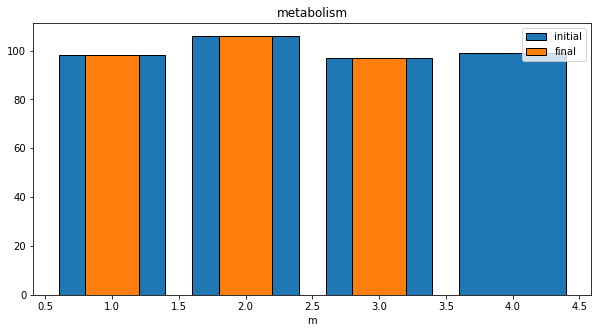

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





#### Vision

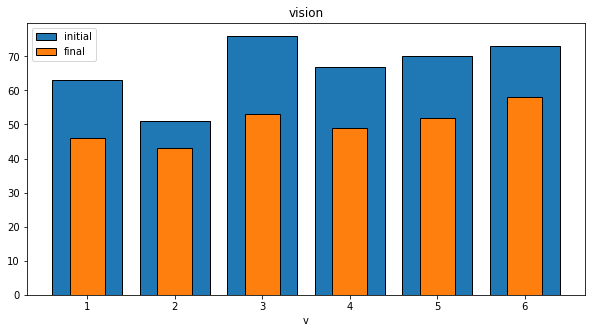

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

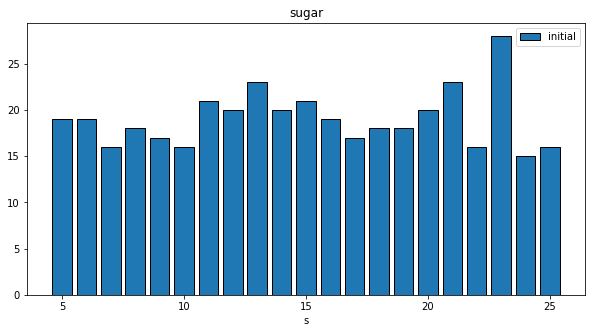

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

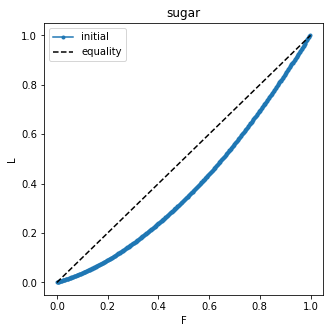

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


